In [174]:
import numpy as np
import pandas as pd
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%store -r dat
dat.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,year,month,day,hour
0,2012-01-01 01:00:00,-4.187027,498.272491,132.585444,-4.331107,47.011057,1.646980,1.498874,0.148436,0.977048,1.650631,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,year 2012,month 1,day 1,hour 1
1,2012-01-01 02:00:00,-4.513490,498.346536,132.155846,-5.144637,46.609310,1.407817,1.453446,-0.012474,1.005379,1.575515,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,year 2012,month 1,day 1,hour 2
2,2012-01-01 03:00:00,-4.419986,498.324978,132.239725,-4.864652,46.660838,1.674208,1.402759,0.121875,0.938557,1.432068,1312.18,-0.175527,0.039879,-0.614344,0.139576,year 2012,month 1,day 1,hour 3
3,2012-01-01 04:00:00,-4.643191,498.548175,132.284963,-5.128783,46.333029,1.395419,1.656221,0.002041,0.949993,1.241215,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,year 2012,month 1,day 1,hour 4
4,2012-01-01 05:00:00,-4.802056,498.790885,131.710328,-5.345652,46.133068,1.502969,1.336300,0.021828,0.763201,1.427051,1317.19,-0.368202,0.156292,-0.810044,0.343843,year 2012,month 1,day 1,hour 5


## Normalization of the variables

In [175]:
#This step is important for the linear regression done later
dat_y = dat.loc[:,['year','month','day','hour','V0','V1']]
dat_x = dat.loc[:,'V2':'V15'].apply(lambda  x: (x-x.mean())/x.std(),axis=0)
dat = pd.concat([dat_y,dat_x],axis=1)
dat.head()

,year,month,day,hour,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15
0,year 2012,month 1,day 1,hour 1,2012-01-01 01:00:00,-4.187027,0.876997,-2.153926,-2.022831,1.093287,-1.327910,-1.560263,-0.763883,-1.527495,-1.495066,2.296447,0.212812,0.232446,0.130552,0.227837
1,year 2012,month 1,day 1,hour 2,2012-01-01 02:00:00,-4.513490,0.894709,-2.254932,-2.264491,1.044520,-1.389687,-1.581956,-0.829536,-1.506219,-1.530497,2.406267,0.192127,0.233391,0.128852,0.237737
2,year 2012,month 1,day 1,hour 3,2012-01-01 03:00:00,-4.419986,0.889552,-2.235210,-2.181321,1.050775,-1.320877,-1.606159,-0.774720,-1.556402,-1.598159,2.404516,0.227572,0.287866,0.130630,0.334304
3,year 2012,month 1,day 1,hour 4,2012-01-01 04:00:00,-4.643191,0.942942,-2.224574,-2.259782,1.010983,-1.392890,-1.485130,-0.823614,-1.547814,-1.688182,2.440289,0.290732,0.206403,0.267724,0.154868
4,year 2012,month 1,day 1,hour 5,2012-01-01 05:00:00,-4.802056,1.000999,-2.359680,-2.324203,0.986710,-1.365109,-1.637893,-0.815541,-1.688092,-1.600526,2.529847,0.130626,0.362845,0.067405,0.412511


## feature engineering 

In [176]:
##add moving average/max/min on windows 10 and 20
movs=[10,20]
mov_data = pd.DataFrame()
for mov in movs:
    #moving average 
    temp1 = dat.loc[:,'V1':'V15'].apply(lambda  x: x.rolling(window=mov).mean(),axis=0)
    temp1.columns = str(mov) + ' mov avg ' + temp1.columns

    #moving max
    temp2 = dat.loc[:,'V1':'V15'].apply(lambda  x: x.rolling(window=mov).max(),axis=0)
    temp2.columns = str(mov) +' mov max ' + temp2.columns

    #moving min
    temp3 = dat.loc[:,'V1':'V15'].apply(lambda  x: x.rolling(window=mov).min(),axis=0)
    temp3.columns = str(mov) + ' mov min ' + temp3.columns

    mov_data = pd.concat([temp1,temp2,temp3,mov_data],axis=1)[40:]
print(mov_data.shape)

(70051, 90)


In [177]:
prv_data = pd.DataFrame()
for i in range(7,17):
    #print(i)
    temp = dat.loc[:,'V1':'V15'].shift(i)
    temp.columns = str(i) + ' lag ' + temp.columns
    prv_data = pd.concat([temp,prv_data],axis=1)
prv_data = prv_data[40:]
prv_data.shape

(70051, 150)

In [178]:
#one hot encoding
list_one_hot = ['year','month','day','hour']
for i in list_one_hot:
    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(dat[i])
    # Drop column B as it is now encoded
    dat = dat.drop(i,axis = 1)
    # Join the encoded df
    dat = dat.join(one_hot)
  
  #delete time stamp
dat.shape

(70091, 91)

In [179]:
#Connect of all new databases
dat_new = pd.concat([dat[40:],prv_data,mov_data],axis=1)
del dat_new['V0']
#Sanity test
print(dat_new.shape)
print(dat[40:].shape,prv_data.shape,mov_data.shape)
print('******')
#Divide data to train\test, x\y, 7 hours ahead
#x/y
y_dat = dat_new.loc[:,'V1']
x_dat = dat_new.loc[:, dat_new.columns != 'V1']

#shift 7 hours ahead  
y_dat = y_dat[7:]
x_dat = x_dat[:-7]

#train\test
x_train, x_test, y_train, y_test = train_test_split(x_dat, y_dat, test_size=0.2,shuffle=False)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)


(70051, 330)
(70051, 91) (70051, 150) (70051, 90)
******
(56035, 329) (14009, 329)
(56035,) (14009,)


## model fit

In [180]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('DT',DecisionTreeRegressor(max_depth=12, min_samples_leaf=7, min_samples_split=7)))
models.append(('RF',RandomForestRegressor(n_estimators=500 ,max_depth=12, min_samples_leaf=7, min_samples_split=7)))
models.append(('XG',XGBRegressor(n_estimators=500)))

# evaluate each model in turn
results = []
names = []
rmses = []
for name, model in models:
    if name=='XG':
        model.fit(x_train, y_train, early_stopping_rounds=5,eval_set=[(x_test, y_test)], verbose=False)
    else:
        model.fit(x_train, y_train)
    y_predict_test = model.predict(x_test)
    y_predict_train = model.predict(x_train)
    results.append(y_predict_test)
    names.append(name)
    rmse_train = sqrt(mean_squared_error(y_train, y_predict_train))
    rmse_test = sqrt(mean_squared_error(y_test, y_predict_test))
    rmses.append(rmse_test)
    print("%s: RMSE train %f RMSE test %f" % (name,rmse_train,rmse_test))
    r2_train = r2_score(y_predict_train, y_train)
    r2_test = r2_score(y_predict_test, y_test)
    print("%s: r2 train   %f r2 test   %f" % (name,r2_train,r2_test))





LR: RMSE train 1.097776 RMSE test 1.115395
LR: r2 train   0.927344 r2 test   0.915242
DT: RMSE train 0.912648 RMSE test 1.512749
DT: r2 train   0.950885 r2 test   0.847685
RF: RMSE train 0.765437 RMSE test 1.229723
RF: r2 train   0.964386 r2 test   0.894172
[22:58:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG: RMSE train 0.976073 RMSE test 1.102236
XG: r2 train   0.942314 r2 test   0.916470


## goodnes of fit

In [238]:
#inesrt the lowest rmse to y_predict_test 
x = np.argmin(rmses)
print("%s has lowest RMES on test with %f" % (names[x],rmses[x]))
y_predict_test = results[x]

XG has lowest RMES on test with 1.102236


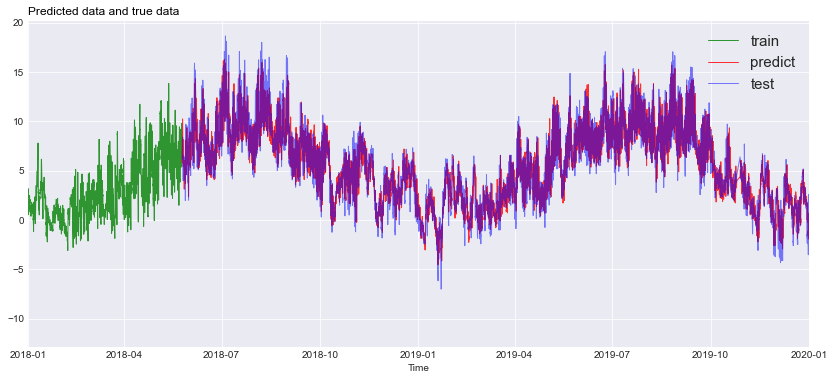

In [239]:
temp = pd.DataFrame(y_test)
temp['predict'] = y_predict_test
temp.columns = ['test', 'predict']
final = pd.concat([temp, y_train], axis=1)
final = pd.concat([final,dat.V0],axis=1)
final = final.set_index('V0')

palette = plt.get_cmap('Set1')
plt.figure(figsize=(14,6))
plt.plot(final.index.values, final.V1, linewidth=1, alpha=0.8,color='green',label='train')
plt.plot(final.index.values, final.predict, linewidth=1, alpha=0.8,color='red',label='predict')
plt.plot(final.index.values, final.test, linewidth=1, alpha=0.5,color='blue',label='test')
plt.title("Predicted data and true data ", loc='left', fontsize=12, fontweight=0, color='black')
plt.xlabel("Time")
plt.ylabel("")
plt.legend(prop={'size': 15})
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2020-01-01'))
plt.show()

In [237]:
#Comparison of basic parameters between test and predict
from scipy.stats.stats import pearsonr   
disc = pd.DataFrame(data=y_test).describe()
disc.columns = ['test']
disc['predict'] = pd.DataFrame(data=y_predict_test).describe()
#print(type(temp1))
#x = temp1.merge(temp2,on='index')
print("There is a correlation of %f between V1 test to V1 predict" % np.corrcoef(y_test,y_predict_test)[0,1])
disc

There is a correlation of 0.962548 between V1 test to V1 predict


,test,predict
count,14009.000000,14009.000000
mean,5.650260,5.583554
std,4.047138,3.813905
min,-7.012340,-4.545477
25%,2.545911,2.554968
50%,5.529614,5.498752
75%,8.510566,8.414661
max,18.674763,16.311760
